
## 기초 분류 모델 만들기

라이브러리와 데이터 불러오기
시각화를 위한 폰트 설정
데이터 전처리와 확인
문자 전처리와 확인
학습, 예측 데이터 세트 분리
단어 벡터화(BOW, TF-IDF)
학습과 예측
답안지 불러오기




 



## 라이브러리 로드

* 텍스트 로드와 분석을 위해 필요한 도구를 불러옵니다.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정
* matplotlib 은 한글폰트를 지원하지 않습니다. 텍스트 빈도수, 학습결과 등을 시각화 하기 위해 폰트 설정이 필요합니다. 
* 운영체제에 따라 기본 폰트를 가져와서 설정을 해줍니다. 

In [ ]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


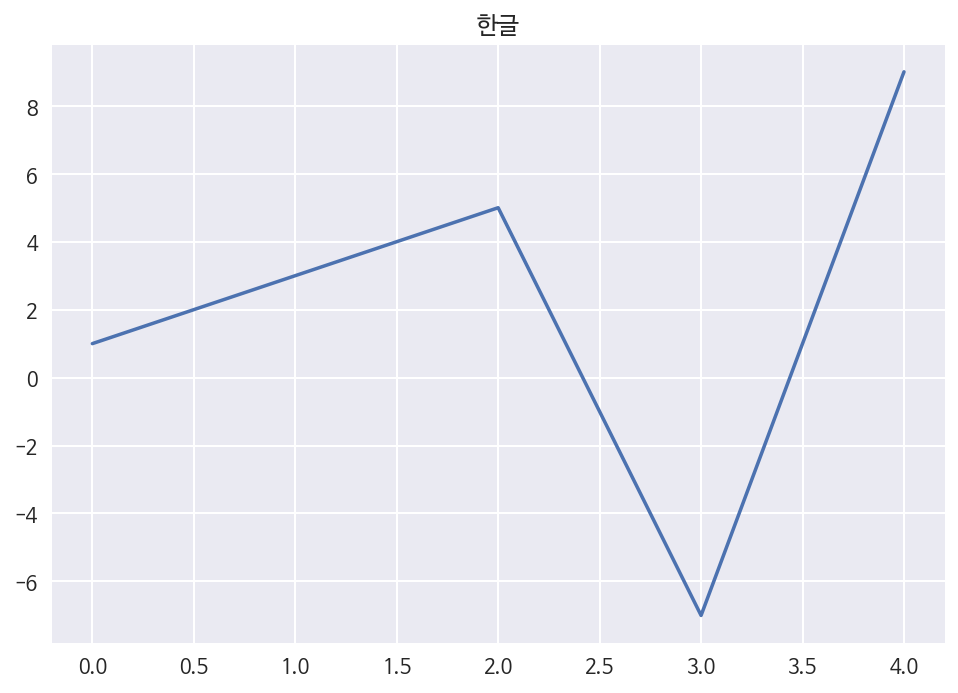

In [ ]:
# 시각화 스타일 설정
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

pd.Series([1, 3, 5, -7, 9]).plot(title="한글")

## 데이터 로드

현재 파일경로에 어떤 파일목록이 있는지 봅니다. ls는 유닉스 계열의 커맨드라인 명령어 입니다. 그래서 윈도우 계열에서는 의도대로 동작하지 않을 수도 있습니다. 최근의 윈도우 운영체제는 대부분 유닉스 계열의 명령어를 지원하지만 운영체제의 버전에 따라 출력이 다르게 보일 수도 있습니다. 중요한 것은 현재 경로에 어떤 파일이 있는지 확인하는 것입니다.

open.zip 으로 된 파일의 압축을 해제합니다. 파일의 압축을 해제하면 train, test, topic, sample_submission 데이터로 구성된 것을 확인할 수 있습니다. 

압축을 해제하고 파일의 목록을 확인하면 csv 확장자로 구성된 파일의 목록을 확인할 수 있습니다.

In [ ]:
# 데이콘의 해당 데이터셋은 CC-BY-4.0 라이센스입니다.
# 데이터 출처 : https://dacon.io/competitions/official/235747/data
# 로컬 PC에서 실습 시 직접 데이콘 사이트에 회원가입하고 다운로드 해주세요.

base_path = "data/klue/"

def file_exist_check(base_path):
    import os, platform
    if os.path.exists(f"{base_path}train_data.csv"):
        print(f"{os.getcwd()}/{base_path} 경로에 파일이 있음")
        return

    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    if platform.system() == "Linux":
        print(f"파일을 다운로드 하고 {base_path} 경로에 압축을 해제함")
        !wget https://bit.ly/dacon-klue-open-zip
        !unzip dacon-klue-open-zip -d data/klue
        return 
    else:
        print(f"""https://dacon.io/competitions/official/235747/data 에서 다운로드 하고
              실습 경로 {os.getcwd()}/{base_path}에 옮겨주세요.""")
        return
    
file_exist_check(base_path) 

파일을 다운로드 하고 data/klue/ 경로에 압축을 해제함
--2022-05-15 06:48:29--  https://bit.ly/dacon-klue-open-zip
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC [following]
--2022-05-15 06:48:29--  https://drive.google.com/uc?export=download&id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.138, 74.125.142.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vtroqqg2as1o2sk0c7c5umb8scll93ep/1652597250000/17163383815352082166/*/1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC?e=download [following]
--2022-05-15 06:48:31--  https://doc-00-6c-do

데이터의 압축을 해제했다면 이제 데이터를 불러올 차례입니다. 파일을 읽는 방법은 여러가지가 있지만 간단하게 데이터프레임 형태로 데이터를 불러올 수 있는 판다스를 사용합니다. 

In [ ]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("data/klue/train_data.csv")
test = pd.read_csv("data/klue/test_data.csv")
train.shape, test.shape

((45654, 3), (9131, 2))

In [ ]:
# 토픽을 불러옵니다.
topic = pd.read_csv("topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


## 전처리를 위한 데이터 병합
* 학습, 예측 세트를 똑같이 전처리 해주기 위해 각각 같은 방법을 적용해 줄 수도 있지만 두 데이터를 병합해서 전처리를 해주고 다시 나눠주겠습니다. 

In [ ]:
topic["topic"].values

array(['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'], dtype=object)

pandas의 conacat 을 통해 train, test 두 데이터 프레임을 하나의 데이터프레임으로 만듭니다. 이렇게 두 개의 데이터프레임을 하나로 합쳐주면 전처리를 한번에 할 수 있다는 장점이 있습니다. 다시 나눌 때는 topic_idx 값이 결측치인지 여부에 따라 나누게 되면 원래의 train, test로 만들어 줄 수 있습니다.

In [ ]:
# 전처리를 위해 데이터 병합
raw = pd.concat([train, test])
raw.shape

(54785, 3)

병합을 해주었다면 병합된 내용이 맞는지 확인합니다. topic_idx는 train 데이터에만 존재합니다. test의 topic_idx는 NaN(Not a Number)로 결측치임을 확인할 수 있습니다.

In [ ]:
raw.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0


In [ ]:
raw.tail()

,index,title,topic_idx
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여,NaN
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개,NaN
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계,NaN
9130,54784,유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구,NaN


이번에는 merge를 통해 topic의 원래 명칭을 찾아줍니다. train과 test를 병합한 데이터에 topic 데이터프레임을 merge로 병합합니다. merge를 사용하게 되면 두 데이터프레임에 공통되는 컬럼이 있다면 해당 컬럼을 키값으로 연결합니다. 두 데이터 프레임에 모두 topic_idx 라는 컬럼이 존재하기 때문에 해당 컬럼을 기준으로 데이터를 병합해 줍니다.


In [ ]:
df = raw.merge(topic, how="left")
df.shape

(54785, 4)

In [ ]:
df.head()

,index,title,topic_idx,topic
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계


## 정답값 빈도수
* train 에서 제공하는 정답값의 빈도수를 구해봅니다. 예측해야 하는 값의 빈도수가 비슷한지 차이가 있는지를 확인합니다.

In [ ]:
# test는 결측치로 되어 있기 때문에 빈도수에 포함되지 않습니다.
df["topic_idx"].value_counts()

4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: topic_idx, dtype: int64

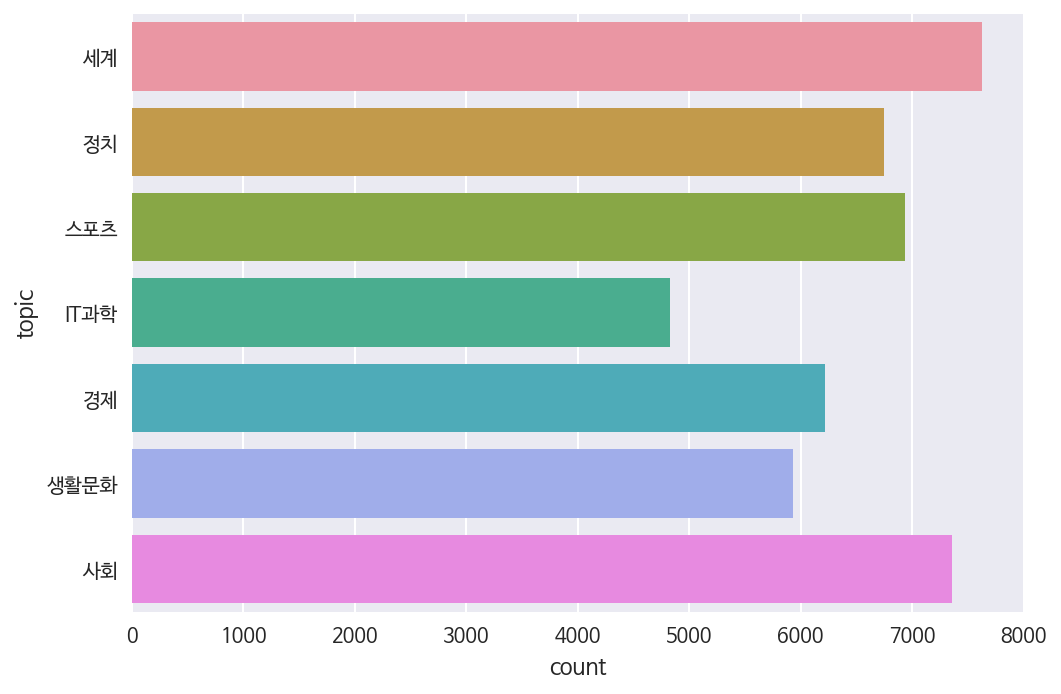

In [ ]:
# df 로 빈도수를 구했지만 test 데이터는 topic이 결측치라 포함되지 않습니다. 
sns.countplot(data=df, y="topic")

## 문자 길이

학습과 예측에 사용할 문자와 단어의 빈도수를 확인해 봅니다. 빈도수를 데이터프레임에 넣고 시각화 해보려고 합니다.

In [ ]:
# 문자, 단어 빈도수 파생변수 만들기
df["len"] = df["title"].apply(lambda x : len(x))
df["word_count"] = df["title"].apply(lambda x : len(x.split()))
df["unique_word_count"] = df["title"].apply(lambda x : len(set(x.split())))

In [ ]:
# 파생변수가 잘 만들어졌는지 확인하기
df.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7


연합뉴스 기사에서 제목만 추출했기 때문에 글자수가 20 ~ 30 사이에 빈도수가 몰려있습니다. 단어수도 6 ~ 8개 내외로 구성이 되어있습니다.

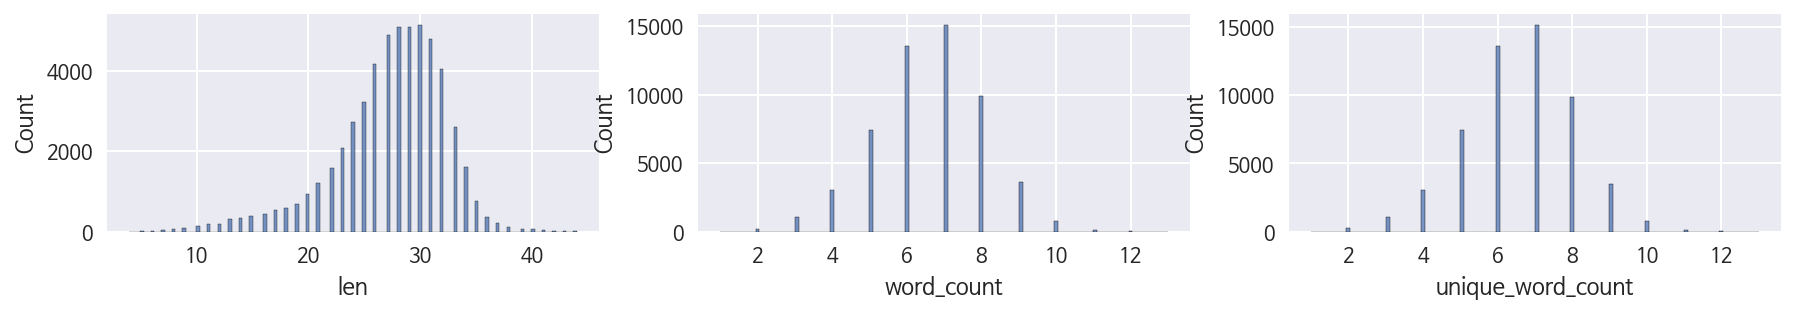

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
sns.histplot(df["len"], ax=axes[0])
sns.histplot(df["word_count"], ax=axes[1])
sns.histplot(df["unique_word_count"], ax=axes[2])

In [ ]:
df[["len", "word_count", "unique_word_count"]].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,27.318846,6.587880,6.576198
std,4.947738,1.471852,1.465320
min,4.000000,1.000000,1.000000
25%,25.000000,6.000000,6.000000
50%,28.000000,7.000000,7.000000
75%,31.000000,8.000000,8.000000
max,44.000000,13.000000,13.000000


### 주제별 글자와 단어 수

topic 별로 단어수의 분포를 보면 큰 차이는 없지만 IT과학, 생활문화는 y축값이 다른 주제에 비해 낮습니다. 이는 정답값의 빈도수와 비교해볼 필요가 있습니다. 이전에 시각화 했던 정답값을 보면 해당 주제의 데이터가 다른 주제에 비해 빈도수가 적음을 알수 있습니다.

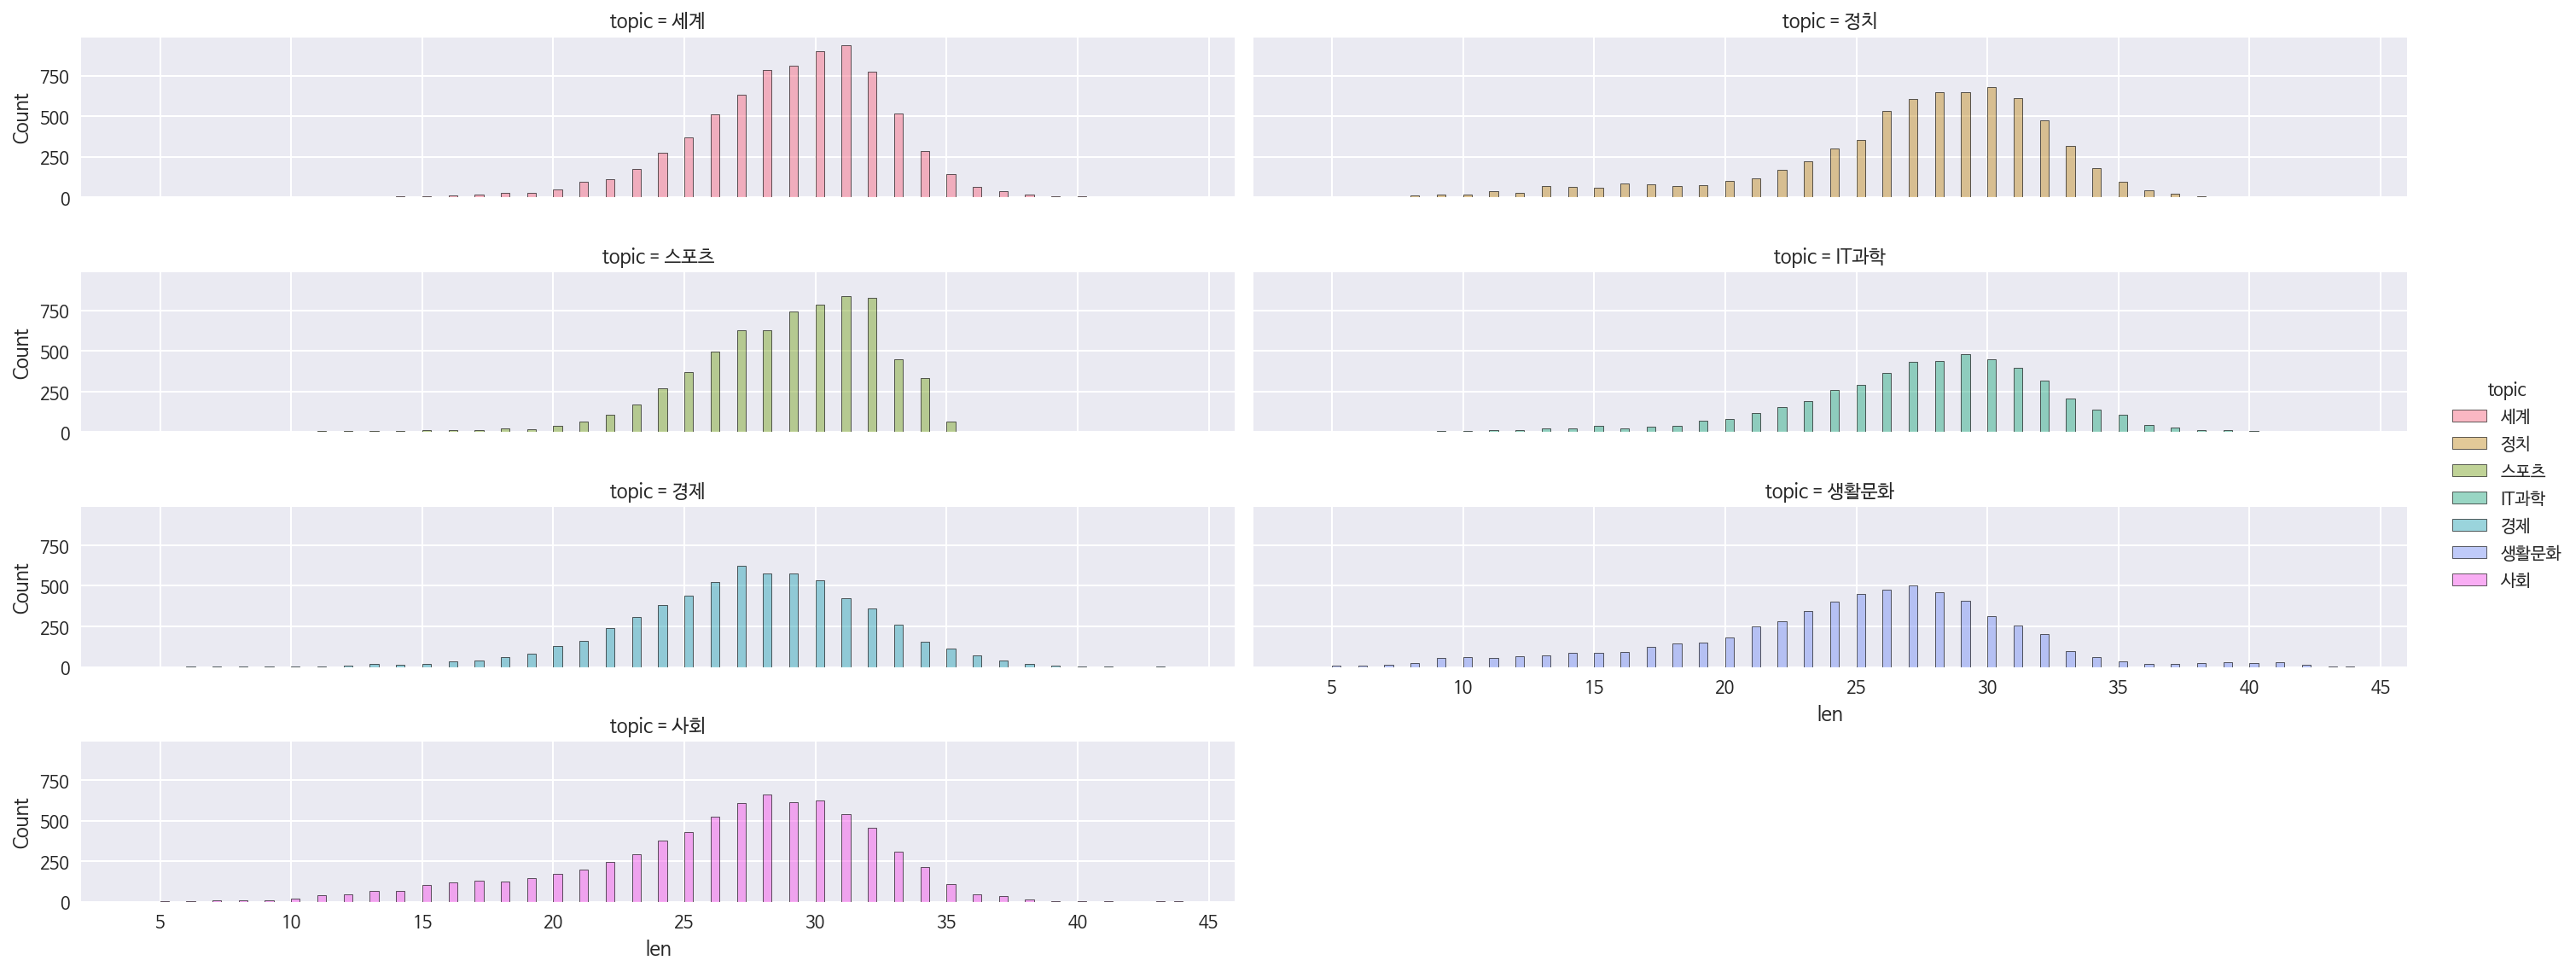

In [ ]:
sns.displot(data=df, x="len",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)

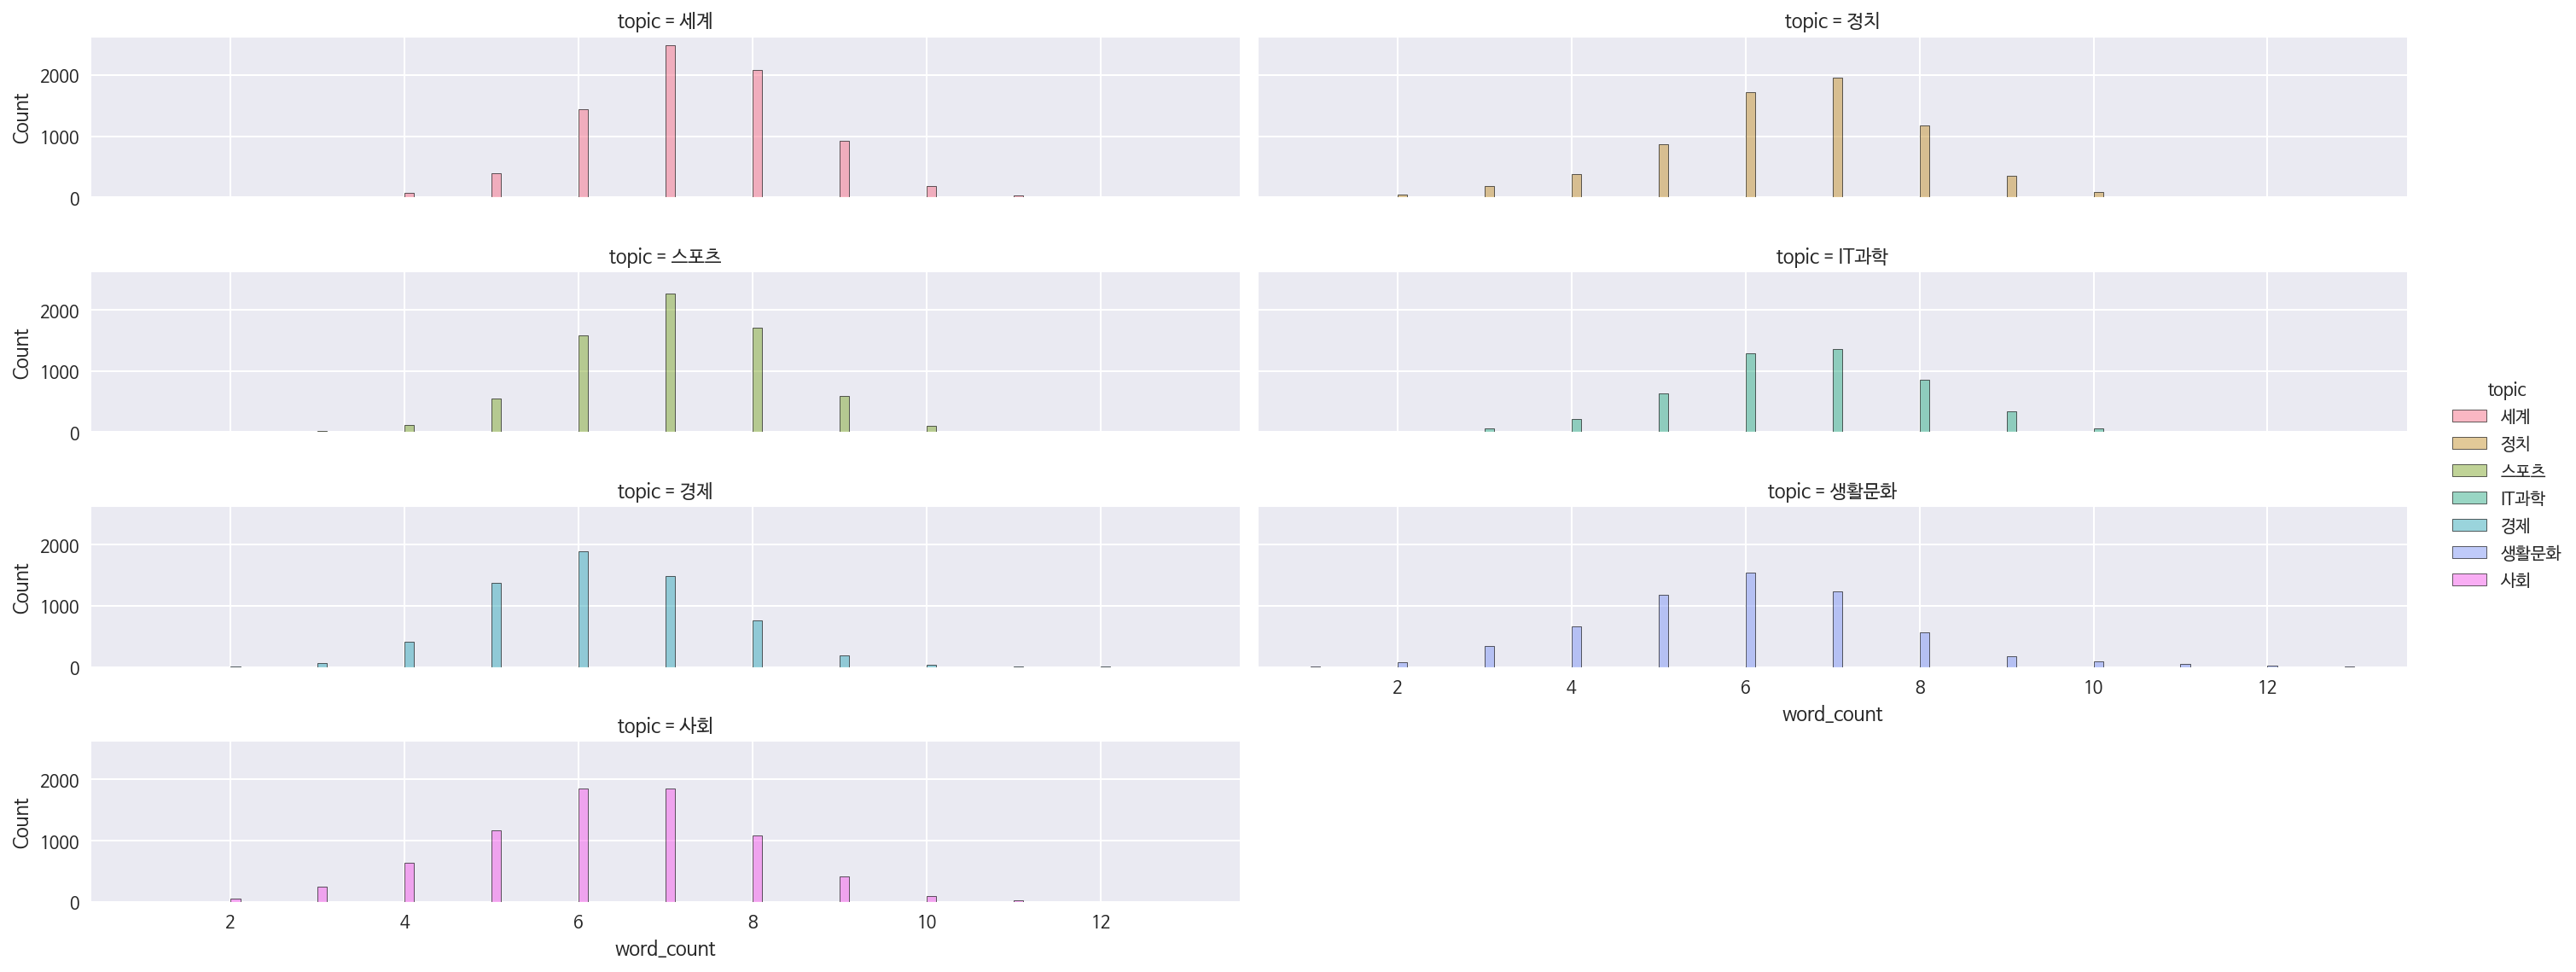

In [ ]:
sns.displot(data=df, x="word_count",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)

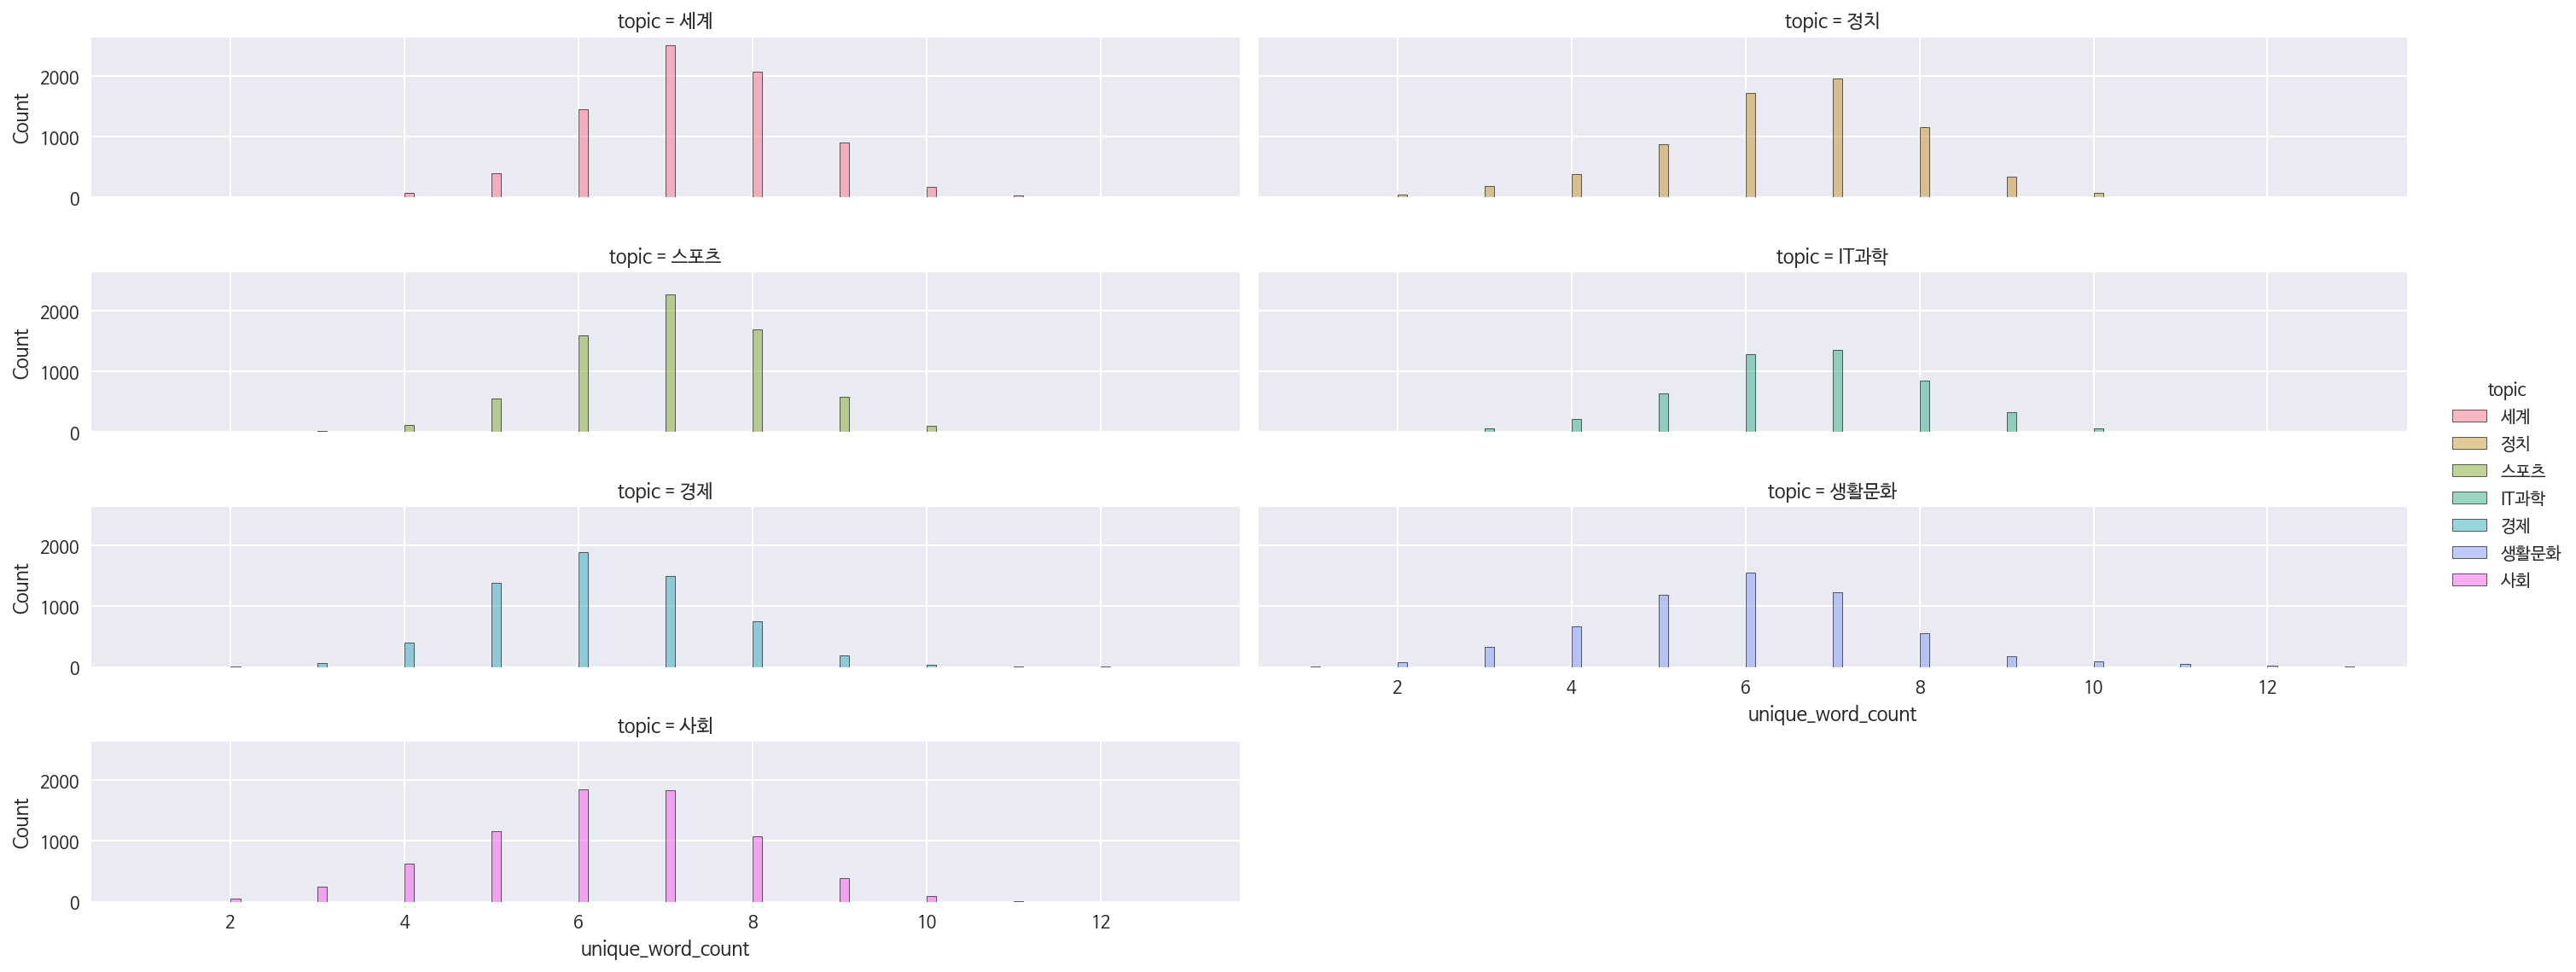

In [ ]:
sns.displot(data=df, x="unique_word_count",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)

## 문자 전처리
단어를 띄어쓰기 단위 등으로 나누어 벡터화를 하는 Bag of Word 방법을 사용하게 되면 대소문자나 숫자 등에 따라 중복된 단어사전이 생성되기도 합니다. 단어 사전이 너무 많아지게 되면 학습 속도가 오래 걸리며 과적합이 발생할 수도 있습니다. 그래서 불필요한 단어를 제거해 주게되면 모델의 성능이 올라가게 됩니다. 전처리를 하는 방법으로는 이렇게 불필요한 문자를 제거해 주는 방법도 있지만 형태소 분석기 등을 사용해서 불필요한 조사 등을 제거해주거나 형태소를 표기해서 같은 단어이지만 다른 의미를 갖는 단어들을 구분해 줄 수도 있습니다. 

판다스는 문자열을 전처리하기 위한 편리한 기능을 제공합니다. 파이썬의 문자열에서 사용할 수 있는 메소드의 일부를 .str accessor를 통해 사용할 수 있습니다. 판다스로 전처리를 하면 반복문을 사용하지 않고 연산을 하기 때문에 빠르게 전처리를 할 수 있습니다. 또 정규표현식을 함께 사용하면 텍스트 전처리를 간편하게 해볼 수 있습니다.

### 숫자 제거

숫자는 학습과 예측에 중요한 역할을 하기도 하고 그렇지 않기도 합니다. 그래서 숫자 사용여부에 대해서는 해당 분야에 대한 이해를 바탕으로 전처리를 해야 합니다.


In [ ]:
import re
# df["title"] = df["title"].map(lambda x : re.sub("[0-9]", "", x))
df["title"] = df["title"].str.replace("[0-9]", "", regex=True)

### 영문자는 모두 소문자로 변경

대소문자가 섞여 있으면 다른 다른 단어로 다루기 때문에 영문자는 모두 대문자 혹은 소문자로 변경합니다.

In [ ]:
df["title"] = df["title"].str.lower()

### 불용어 제거

불용어는 보통 Stop Word로 부릅니다. 나, 너, 그, 등과 같이 문장을 구성하는 필수 요소이지만 문장 내에서 자주 등장하지만 중요한 의미를 갖지 않는 대명사 등을 의미하게 됩니다. Bag of Word 방식에서는 이런 단어들이 자주 등장하지만 중요한 의미를 갖고 있지 않기 때문에 제거해 주면 성능이 높아지기도 하지만 낮아질 수도 있으니 적절하게 제거해야 합니다. 영어는 nltk를 통해 불용어 사전을 제공하고 있지만 한국어는 불용어 사전이 따로 없습니다. 그래서 불용어 사전을 만든다면 해당 분야를 잘 이해하고 불용어 사전을 만드는게 좋습니다. 또 불용어를 전처리 한다면 전처리 전후에 모델의 성능이 좋아지는 여부를 확인하고 불용어를 추가하거나 제거해야 합니다.

In [ ]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그 ', ' 등', '이런', ' 것 ', ' 및 ',' 제 ', ' 더 ']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [ ]:
df["title"] = df["title"].map(remove_stopwords)

## 학습, 예측 데이터셋 분리

전처리가 되었다면 다시 학습과 예측 데이터셋으로 분리합니다. 데이터를 다시 분리할 때는 정답값인 topic_idx 값 여부에 따라 나눌 수 있습니다. 판다스의 notnull()과 isnull() 기능을 사용하여 학습과 예측 데이터셋을 나눕니다.

In [ ]:
label_name = "topic_idx"

In [ ]:
train = df[df[label_name].notnull()]
test = df[df[label_name].isnull()]
train.shape, test.shape

In [ ]:
X_train = train["title"]
X_test = test["title"]

X_train.shape, X_test.shape

In [ ]:
y_train = train[label_name]
y_train.value_counts()

In [ ]:
y_test = test[label_name]
y_test.value_counts()

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용 되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

* 출처 : [tf-idf - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/Tf-idf)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=None, 
                             ngram_range=(1,2),
                             min_df=3, 
                             max_df=0.95)
tfidf_vect.fit(X_train)

In [ ]:
train_feature_tfidf = tfidf_vect.transform(X_train)
test_feature_tfidf = tfidf_vect.transform(X_test)

train_feature_tfidf.shape, test_feature_tfidf.shape

In [ ]:
# 단어 사전
vocab = tfidf_vect.get_feature_names()
print(len(vocab))
vocab[:10]

In [ ]:
# np.sum 으로 위에서 구한 train_feature_vector 의 값을 모두 더합니다. axis=0 으로 합니다. 
dist = np.sum(train_feature_tfidf, axis=0)

vocab_count = pd.DataFrame(dist, columns=vocab)
vocab_count

In [ ]:
# 위에서 구한 빈도수를 그래프로 그립니다.
vocab_count.T[0].sort_values(ascending=False).head(50).plot.bar(figsize=(15, 4))

## 학습과 예측

In [ ]:
# RandomForestClassifier 를 불러옵니다.
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42)
model

In [ ]:
from lightgbm import LGBMClassifier

# lightgbm 분류기 사용
model = LGBMClassifier(random_state=42)
model

### 교차 검증

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, train_feature_tfidf, y_train, cv=3, n_jobs=-1, verbose=1)

### 교차 검증 정확도

In [ ]:
valid_accuracy = (y_pred == y_train).mean()
valid_accuracy

In [ ]:
df_accuracy = pd.DataFrame({"pred": y_pred, "train": y_train})
df_accuracy["accuracy"] = (y_pred == y_train)

In [ ]:
topic

In [ ]:
df_accuracy.groupby(["train"])["accuracy"].mean()

In [ ]:
df_accuracy.rename(columns={"pred":"predict"})

### 학습

학습을 하는 과정은 마치 우리가 시험공부를 하고 시험을 보는 과정과 비슷합니다. 운전면허 시험을 본다고 가정하면 우리는 기출문제집을 풀며 학습을 하고 실제 시험을 보러 갈 것입니다. 기출문제집에는 정답이 있지만 실제 시험에는 정답이 없습니다. 데이터 예측도 마찬가지 입니다. 학습 데이터에는 정답이 있지만 예측 데이터인 test에는 정답이 없습니다. 우리가 정답을 예측해서 리더보드에 올리면 평가지표에 따라 얼마나 정확하게 예측했는지 점수를 알 수 있습니다. 우리가 운전면허 시험이나 수능시험을 볼 때 시험이 끝나고 점수를 받는 것과 비슷합니다.

In [ ]:
# fit 으로 학습시킵니다.
%time model.fit(train_feature_tfidf, y_train)

### 예측

학습한 모델을 통해 예측을 합니다. 예측된 결과는 리더보드에 올려 얼마나 정확하게 예측했는지 평가지표에 따라 점수를 측정합니다.

In [ ]:
# predict로 예측합니다. 
y_predict = model.predict(test_feature_tfidf)
y_predict[:5]

## 답안지 로드

sample_submission.csv 파일은 마치 답안지와 같습니다.

In [ ]:
submit = pd.read_csv("sample_submission.csv")
submit.head()

In [ ]:
# 정답값 측정을 위해 y_test 변수에 할당
submit["topic_idx"] = y_predict

In [ ]:
submit.to_csv(f"submit_{valid_accuracy}.csv", index=False)

## 여러 방법을 통해 예측비율을 높여보세요. 
* 학습 세트와 테스트 세트의 비율을 7:3으로 유지하도록 하고 다음의 방법들을 사용해 볼 수 있습니다. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경